In [1]:
import os
import torch
import numpy as np
import sys
import os

project_root_dir = "/data1/1shared/jinjiarui/run/Diffusion-TS"
sys.path.append(project_root_dir)
os.chdir(project_root_dir)

from engine.solver import Trainer
from utils.metric_utils import visualization
from data.build_dataloader import build_dataloader
from utils.io_utils import load_yaml_config, instantiate_from_config
from models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one
from data.build_dataloader import build_dataloader_cond

/home/jinjiarui/anaconda3/envs/diffusionts/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args_Example:
    def __init__(self) -> None:
        self.gpu = 0
        self.config_path = "./config/ptbxl.yaml"
        self.save_dir = "./results/ptbxl_syn_exp"
        self.mode = "synthesis_channel"
        self.synthesis_channels = list(range(1, 12))
        self.milestone = 10
        os.makedirs(self.save_dir, exist_ok=True)

In [3]:

args = Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f"cuda:{args.gpu}" if torch.cuda.is_available() else "cpu")

print(f"args.mode: {args.mode}")

dl_info = build_dataloader_cond(configs, args)
model = instantiate_from_config(configs["model"]).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

trainer.load(args.milestone)

args.mode: synthesis_channel


train data scale: -85.1923070438868 73.20585783243013
train data scale: -1.0 1.0


In [4]:
dataloader, dataset = dl_info["dataloader"], dl_info["dataset"]
coef = configs["dataloader"]["test_dataset"]["coefficient"]
stepsize = configs["dataloader"]["test_dataset"]["step_size"]
sampling_steps = configs["dataloader"]["test_dataset"]["sampling_steps"]
seq_length, feature_dim = dataset.window, dataset.var_num

In [ ]:
samples, ori_data, masks = trainer.restore(
    dataloader, [seq_length, feature_dim], coef, stepsize, sampling_steps
)

# if dataset.auto_norm:
#     samples = unnormalize_to_zero_to_one(samples)

conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

conditional sampling loop time step:   8%|▊         | 15/200 [00:12<02:49,  1.09it/s]

In [5]:


ori_data = np.load(
    os.path.join(dataset.dir, f"ground_truth_{seq_length}_test.npy")
)
# ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_test.npy"))  # Uncomment the line if dataset other than Sine is used.
masks = np.load(os.path.join(dataset.dir, f"masking_{seq_length}.npy"))
sample_num, seq_len, feat_dim = ori_data.shape
observed = ori_data * masks


NameError: name 'samples' is not defined

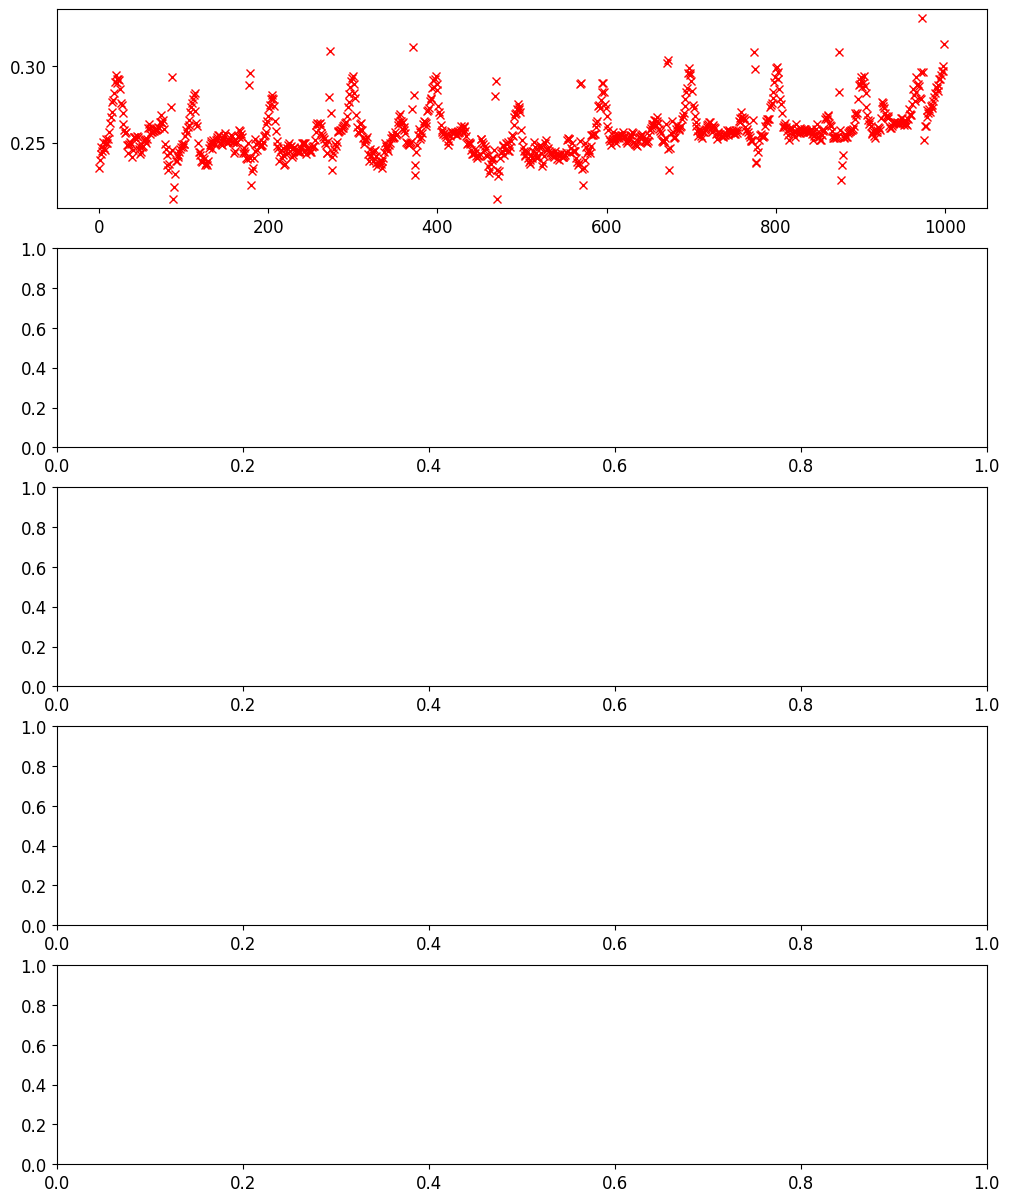

In [6]:
from matplotlib import pyplot as plt
import pandas as pd

plt.rcParams["font.size"] = 12
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))
for feat_idx in range(feat_dim):
    df_x = pd.DataFrame(
        {
            "x": np.arange(0, seq_len),
            "val": ori_data[0, :, feat_idx],
            "y": masks[0, :, feat_idx],
        }
    )
    df_x = df_x[df_x.y != 0]

    df_o = pd.DataFrame(
        {
            "x": np.arange(0, seq_len),
            "val": ori_data[0, :, feat_idx],
            "y": (1 - masks)[0, :, feat_idx],
        }
    )
    df_o = df_o[df_o.y != 0]
    axes[feat_idx].plot(df_o.x, df_o.val, color="b", marker="o", linestyle="None")
    axes[feat_idx].plot(df_x.x, df_x.val, color="r", marker="x", linestyle="None")
    axes[feat_idx].plot(
        range(0, seq_len),
        samples[0, :, feat_idx],
        color="g",
        linestyle="solid",
        label="Diffusion-TS",
    )
    plt.setp(axes[feat_idx], ylabel="value")
    if feat_idx == feat_dim - 1:
        plt.setp(axes[-1], xlabel="time")

In [ ]:
plt.show()